# CREATING SYNTHETIC DATA

Often, we want to study computational technique by studying existing models.
Frequently, we do not have true observational data, or we want to study the effectiveness
of algorithms with observational data that has different levels of noise.
In these situations, it is useful to create **synthetic observational data**.

We will illustrate the approach using the Wolf model.

The core idea is as follows.
We have an existing model that generates observations $y^{\star}(t)$,
a vector of floating species concentrations for each timepoint.
We add random noise, $n(t)$, to this vector (typically guassian).
The result, $y(t) = y^{\star} (t) + n(t)$, is our synthetic observational data.

# Preliminaries

In [30]:
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [31]:
!pip install -q tellurium

In [32]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te

# Wolf Model

In [33]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;
  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

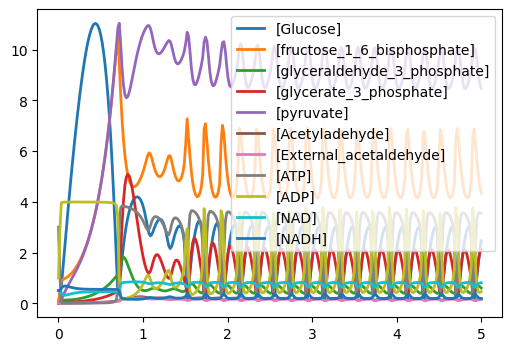

In [34]:
rr = te.loada(WOLF_MODEL)
WOLF_DATA = rr.simulate(0, 5, 300)
rr.plot()

# Simple Noise

By simple noise, we mean that $n(t)$ is a matrix of identically distributed guassians.

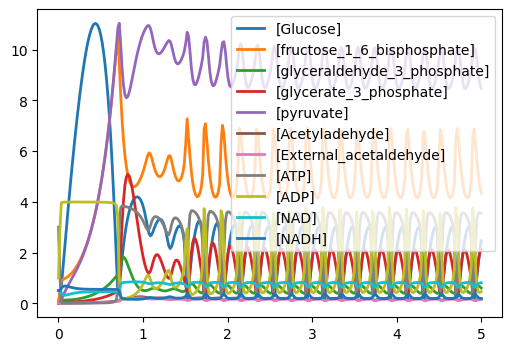

In [35]:
rr.plot()

In [36]:
# Creating pseudo random numbers
np.random.normal(0, 1, 5)

array([ 1.76633335,  0.56251007,  0.30120386, -0.87106344,  0.41415153])

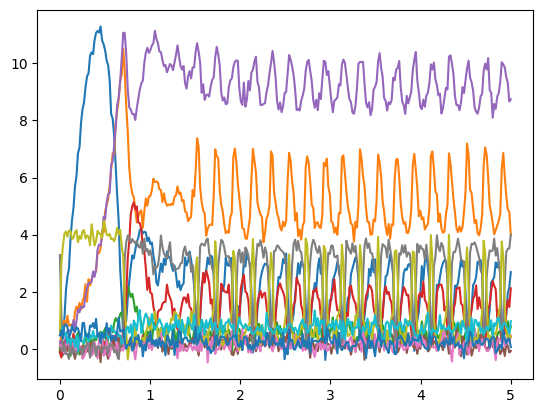

In [37]:
# Construct a mean weighted noise
observeds = WOLF_DATA.copy()
nrow = np.shape(observeds)[0]
ncol = np.shape(observeds)[1]
for icol in range(1, ncol):
    observeds[:, icol] += np.random.normal(0, 0.2, nrow)
    plt.plot(observeds[:, 0], observeds[:, icol])


In [38]:
def generateNoiseyData(simulation_data, std=1, is_plot=True):
    """
    Creates noisey data from a simulation result.

    Args:
        simulation_data: NamedArray (output from te.simulate())
        std: float (standard deviation of noise)
    """
    observeds = simulation_data.copy()
    nrow = np.shape(observeds)[0]
    ncol = np.shape(observeds)[1]
    for icol in range(1, ncol):
        observeds[:, icol] += np.random.normal(0, 0.2, nrow)
        if is_plot:
            plt.plot(observeds[:, 0], observeds[:, icol])
    return observeds

# Tests
noisey_data = generateNoiseyData(WOLF_DATA, std=0.2, is_plot=False)
assert(np.allclose(np.shape(noisey_data), np.shape(WOLF_DATA)))
print("OK!")

OK!


**Problem**: Little effect for large simulation outputs; big effect for small simulation outputs

# Noise Weighted by Mean

Using the same standard deviation for all variables seems inappropriate. Instead, need to adjust for the mean. One approach is to use $σ\bar{x}$, where $\sigma$ is the standard deviation of $\bar{x}$ is the mean value of the variable.

In [40]:
# Modify generateNoiseyData to do adjustment by mean